# Markov Decision Process (MDP)

### Ransalu Senanayake

In [1]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [2]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [3]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

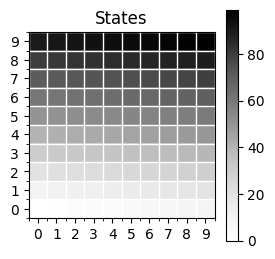

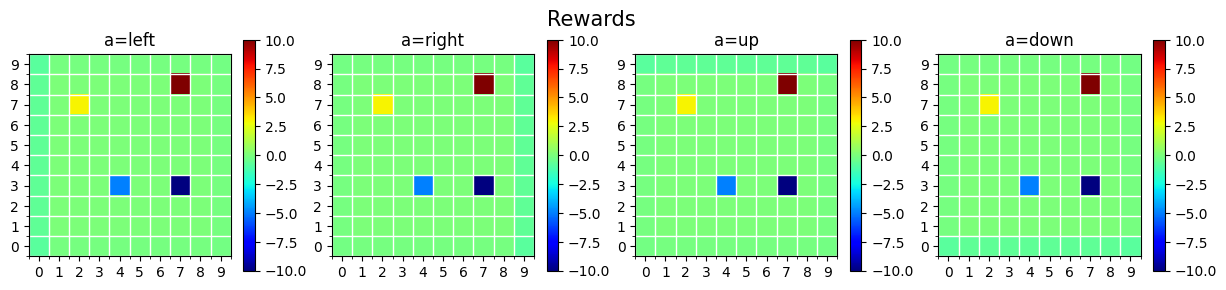

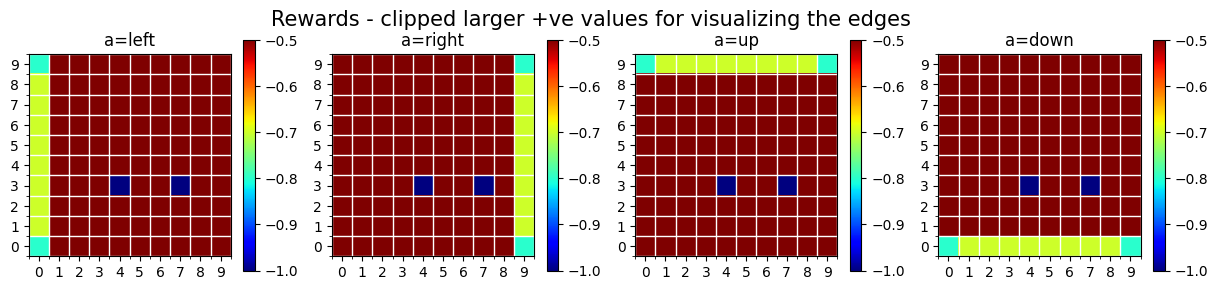

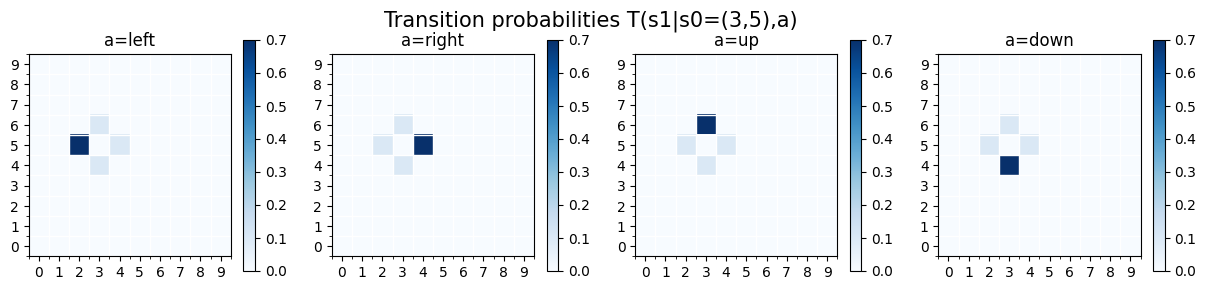

In [4]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [5]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

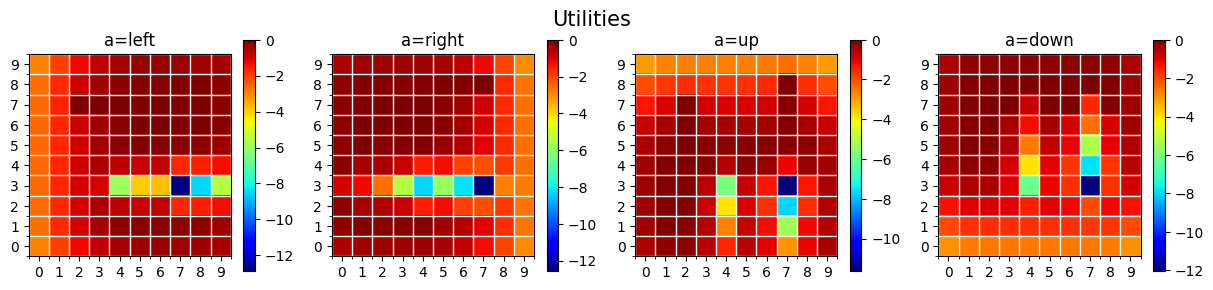

In [10]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    discount = mdp.discount

    for t in range(numIterations):
        U_old = copy.copy(U)
        for s in mdp.S:
            a = policy
            U[s] = sum([mdp.T[s, a, s1] * (mdp.R[s, a] + discount * U_old[s1]) for s1 in mdp.nextStates[(s, a)]])

    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [11]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

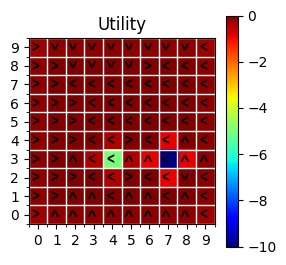

In [12]:
# Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    discount = mdp.discount

    for t in range(numIterations):
        U_old = copy.copy(U)
        for s in mdp.S:

            U[s] = max([sum([mdp.T[s, a, s1] * (mdp.R[s, a] + discount * U_old[s1]) for s1 in mdp.nextStates[(s, a)]]) for a in range(len(mdp.A))])

    return U


def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    discount = mdp.discount

    for s in mdp.S:

        policy[s] = np.argmax([sum([mdp.T[s, a, s1] * (mdp.R[s, a] + discount * U[s1]) for s1 in mdp.nextStates[(s, a)]]) for a in range(len(mdp.A))])

    return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [13]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [14]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S))
    pi_k = np.random.randint(low=0, high=4, size=len(mdp.S), dtype=int)
    pi_kp1 = copy.copy(pi_k)
    discount = mdp.discount

    for t in range(numIterations):

        U_pi_k_old = np.zeros(len(mdp.S))
        for i in range(10):
            U_pi_k_old = copy.copy(U_pi_k)
            for s in mdp.S:
                a = pi_k[s]
                U_pi_k[s] = sum([mdp.T[s, a, s1] * (mdp.R[s, a] + discount * U_pi_k_old[s1]) for s1 in mdp.nextStates[(s, a)]])


        for s in mdp.S:
            pi_kp1[s] = np.argmax([sum([mdp.T[s, a, s1] * (mdp.R[s, a] + discount * U_pi_k[s1]) for s1 in mdp.nextStates[(s, a)]]) for a in range(len(mdp.A))])


        if np.array_equal(pi_k, pi_kp1):
            break


        pi_k = copy.copy(pi_kp1)

    return U_pi_k, pi_kp1

U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

In [15]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

In [16]:
# Question 02
# Q-Learning (Model-Free Approach)
def qLearning(mdp, numEpisodes=1000, alpha=0.1, epsilon=0.1, gamma=0.9):
    Q = np.zeros((len(mdp.S), len(mdp.A)))  # Initialize Q-table to zero
    for episode in range(numEpisodes):
        # Initialize the starting state
        s = np.random.randint(0, len(mdp.S))
        done = False
        while not done:
            # Choose action a (epsilon-greedy strategy)
            if np.random.rand() < epsilon:
                a = np.random.randint(0, len(mdp.A))  # Explore
            else:
                a = np.argmax(Q[s, :])  # Exploit best action

            # Choose next state based on transition probability
            s1 = np.random.choice(mdp.S, p=mdp.T[s, a, :])

            # Get reward
            r = mdp.R[s, a]

            # Update Q-value
            Q[s, a] += alpha * (r + gamma * np.max(Q[s1, :]) - Q[s, a])

            # Set next state
            s = s1

            # End episode when terminal state is reached
            if r == 10 or r == -10:  # Example termination condition (can be modified)
                done = True

    # Extract policy from Q-values
    policy = np.argmax(Q, axis=1)
    return Q, policy

# Modified function to compare both approaches
def f(numIter=1, approach='Policy Iteration'):
    start_time = timeit.default_timer()

    if approach == 'Policy Iteration':
        # Model-Based: Policy Iteration
        value, policy = policyIteration(mdp, numIterations=numIter)
    elif approach == 'Q-Learning':
        # Model-Free: Q-Learning
        value, policy = qLearning(mdp, numEpisodes=numIter)

    elapsed = timeit.default_timer() - start_time
    print('Execution time (ms) =', np.round(elapsed * 1000, 2))

    # Plot the utility/values
    pl.figure(figsize=(3, 3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10, 10), title='Utility', cmap='jet')

    # Visualize policy with arrows
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m = '\u02C2'  # left arrow
        elif policy[s] == 1:
            m = '\u02C3'  # right arrow
        elif policy[s] == 2:
            m = '\u02C4'  # up arrow
        elif policy[s] == 3:
            m = '\u02C5'  # down arrow
        pl.text(x - 0.5, y - 1, m, color='k', size=20)

    pl.show()

# Interactive plot with options for Model-Based (Policy Iteration) and Model-Free (Q-Learning)
interactive_plot = interactive(
    f,
    numIter=widgets.IntSlider(min=1, max=100, step=1, value=10),
    approach=widgets.ToggleButtons(options=['Policy Iteration', 'Q-Learning'])
)
interactive_plot

interactive(children=(IntSlider(value=10, description='numIter', min=1), ToggleButtons(description='approach',…

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np
import matplotlib.pyplot as pl

# Neural Network for approximating Q-values
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Output Q-values for each action

# DQN Algorithm
class DQN:
    def __init__(self, state_size, action_size, discount=0.9, learning_rate=0.001, batch_size=64, replay_buffer_size=10000):
        self.state_size = state_size
        self.action_size = action_size
        self.discount = discount
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Neural networks
        self.policy_net = QNetwork(state_size, action_size)
        self.target_net = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

        # Replay buffer
        self.replay_buffer = deque(maxlen=replay_buffer_size)

        # Copy weights from policy_net to target_net
        self.update_target_network()

    def update_target_network(self):
        """Update the target network with the weights of the policy network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        """Store the experience in the replay buffer."""
        self.replay_buffer.append((state, action, reward, next_state, done))

    def sample_batch(self):
        """Sample a batch of experiences from the replay buffer."""
        return random.sample(self.replay_buffer, min(len(self.replay_buffer), self.batch_size))

    def train(self):
        """Train the policy network using experiences from the replay buffer."""
        if len(self.replay_buffer) < self.batch_size:
            return  # Wait until the buffer has enough samples

        # Sample a batch of transitions
        batch = self.sample_batch()
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        # Get the current Q-values from the policy network
        current_q_values = self.policy_net(states).gather(1, actions)

        # Get the next Q-values from the target network
        next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)

        # Compute the target Q-values
        target_q_values = rewards + (self.discount * next_q_values * (1 - dones))

        # Compute the loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # Backpropagate the loss and update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def act(self, state, epsilon=0.1):
        """Choose an action using an epsilon-greedy strategy."""
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)  # Explore: random action
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
            q_values = self.policy_net(state)
            return torch.argmax(q_values).item()  # Exploit: choose best action

# Function to convert state index to a one-hot vector
def state_to_one_hot(state, num_states=100):
    state_vector = np.zeros(num_states)
    state_vector[state] = 1
    return state_vector

# Updated DQN training loop with one-hot encoded state input
def train_dqn(mdp, dqn_agent, num_episodes=1000, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995):
    epsilon = epsilon_start
    for episode in range(num_episodes):
        state = np.random.randint(0, len(mdp.S))  # Initialize the starting state (scalar index)
        state_vector = state_to_one_hot(state)  # Convert state to one-hot vector
        done = False
        total_reward = 0

        while not done:
            # Choose an action using epsilon-greedy strategy
            action = dqn_agent.act(state_vector, epsilon)

            # Get next state, reward, and done flag
            next_state = np.random.choice(mdp.S, p=mdp.T[state, action, :])
            next_state_vector = state_to_one_hot(next_state)  # Convert next state to one-hot vector
            reward = mdp.R[state, action]
            done = reward == 10 or reward == -10  # Example termination condition
            total_reward += reward

            # Store the transition in the replay buffer
            dqn_agent.store_transition

In [21]:
# Question 3 Part 2
def act(self, state, epsilon):
    """Choose an action using an epsilon-greedy strategy."""
    if random.random() < epsilon:
        return random.randint(0, self.action_size - 1)  # Explore: random action
    else:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
        q_values = self.policy_net(state)
        return torch.argmax(q_values).item()  # Exploit: choose the best action

In [26]:
def train_dqn_with_epsilon(mdp, dqn_agent, epsilon, num_episodes=1000, epsilon_end=0.1, epsilon_decay=0.995):
    rewards_per_episode = []
    for episode in range(num_episodes):
        state = np.random.randint(0, len(mdp.S))  # Initialize the starting state
        state_vector = state_to_one_hot(state)  # Convert state to one-hot vector
        done = False
        total_reward = 0

        while not done:
            # Choose an action using epsilon-greedy strategy
            action = dqn_agent.act(state_vector, epsilon)

            # Get next state, reward, and done flag
            transition_probabilities = mdp.T[state, action, :]
            if transition_probabilities.sum() == 0:
                # Handle the case where all transition probabilities are zero
                transition_probabilities = np.ones_like(transition_probabilities) / len(transition_probabilities)
            else:
                transition_probabilities = transition_probabilities / transition_probabilities.sum()  # Normalize the probabilities

            next_state = np.random.choice(mdp.S, p=transition_probabilities)
            next_state_vector = state_to_one_hot(next_state)  # Convert next state to one-hot vector
            reward = mdp.R[state, action]
            done = reward == 10 or reward == -10  # Example termination condition
            total_reward += reward

            # Store the transition in the replay buffer
            dqn_agent.store_transition(state_vector, action, reward, next_state_vector, done)

            # Train the DQN using the replay buffer
            dqn_agent.train()

            # Move to the next state
            state = next_state
            state_vector = next_state_vector

        # Decay epsilon (only if using decay mechanism, but here we're using fixed epsilon for analysis)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # Update the target network periodically
        if episode % 10 == 0:
            dqn_agent.update_target_network()

        rewards_per_episode.append(total_reward)
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    return rewards_per_episode

Running with epsilon = 0.1
Episode 0, Total Reward: -33.40000000000003, Epsilon: 0.1
Episode 1, Total Reward: -72.80000000000015, Epsilon: 0.1
Episode 2, Total Reward: -82.99999999999997, Epsilon: 0.1
Episode 3, Total Reward: -23.800000000000097, Epsilon: 0.1
Episode 4, Total Reward: -10.0, Epsilon: 0.1
Episode 5, Total Reward: -10.4, Epsilon: 0.1
Episode 6, Total Reward: -2.899999999999986, Epsilon: 0.1
Episode 7, Total Reward: 10.0, Epsilon: 0.1
Episode 8, Total Reward: -5.099999999999982, Epsilon: 0.1
Episode 9, Total Reward: -2.399999999999988, Epsilon: 0.1
Episode 10, Total Reward: -12.100000000000001, Epsilon: 0.1
Episode 11, Total Reward: -15.700000000000081, Epsilon: 0.1
Episode 12, Total Reward: -13.200000000000001, Epsilon: 0.1
Episode 13, Total Reward: 9.0, Epsilon: 0.1
Episode 14, Total Reward: 10.4, Epsilon: 0.1
Episode 15, Total Reward: 12.1, Epsilon: 0.1
Episode 16, Total Reward: 7.299999999999999, Epsilon: 0.1
Episode 17, Total Reward: 8.4, Epsilon: 0.1
Episode 18, Tota

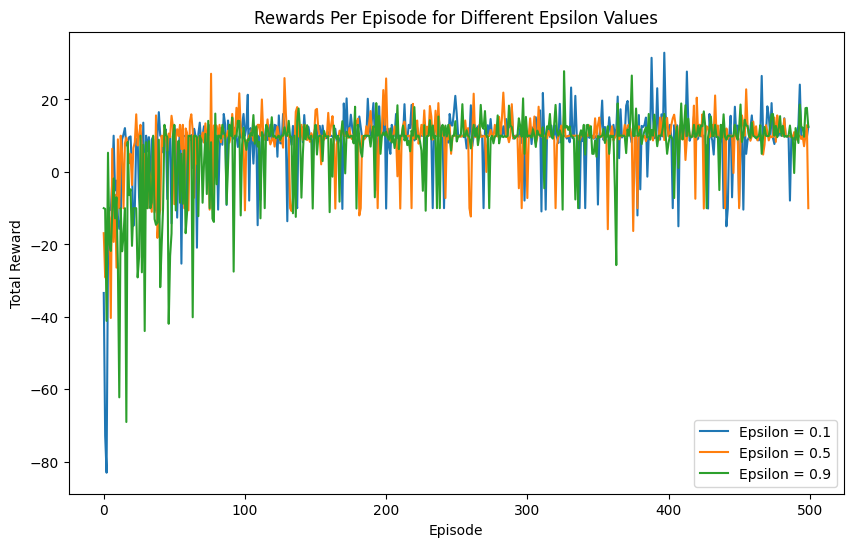

In [28]:
# Train DQN with different epsilon values
epsilon_values = [0.1, 0.5, 0.9]  # Exploration rates
num_episodes = 500

results = {}

# Run the DQN training for each epsilon value and store the rewards
for epsilon in epsilon_values:
    print(f"Running with epsilon = {epsilon}")
    dqn_agent = DQN(state_size, action_size)  # Re-initialize agent for each experiment
    rewards = train_dqn_with_epsilon(mdp, dqn_agent, epsilon, num_episodes=num_episodes)
    results[str(epsilon)] = rewards  # Store the results using string keys

# Plot rewards for different epsilon values
plt.figure(figsize=(10, 6))
for epsilon in epsilon_values:
    plt.plot(results[str(epsilon)], label=f"Epsilon = {epsilon}")

plt.title("Rewards Per Episode for Different Epsilon Values")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

Running with epsilon = 0.1
Episode 0, Total Reward: -57.60000000000006, Epsilon: 0.1
Episode 1, Total Reward: -29.8, Epsilon: 0.1
Episode 2, Total Reward: -42.69999999999996, Epsilon: 0.1
Episode 3, Total Reward: -15.0, Epsilon: 0.1
Episode 4, Total Reward: 9.0, Epsilon: 0.1
Episode 5, Total Reward: -10.1, Epsilon: 0.1
Episode 6, Total Reward: -10.3, Epsilon: 0.1
Episode 7, Total Reward: -15.0, Epsilon: 0.1
Episode 8, Total Reward: -10.0, Epsilon: 0.1
Episode 9, Total Reward: -12.0, Epsilon: 0.1
Episode 10, Total Reward: 8.0, Epsilon: 0.1
Episode 11, Total Reward: 5.3000000000000025, Epsilon: 0.1
Episode 12, Total Reward: -10.0, Epsilon: 0.1
Episode 13, Total Reward: 2.500000000000007, Epsilon: 0.1
Episode 14, Total Reward: -10.9, Epsilon: 0.1
Episode 15, Total Reward: -20.699999999999996, Epsilon: 0.1
Episode 16, Total Reward: 5.899999999999999, Epsilon: 0.1
Episode 17, Total Reward: -14.7, Epsilon: 0.1
Episode 18, Total Reward: -13.200000000000001, Epsilon: 0.1
Episode 19, Total Rewa

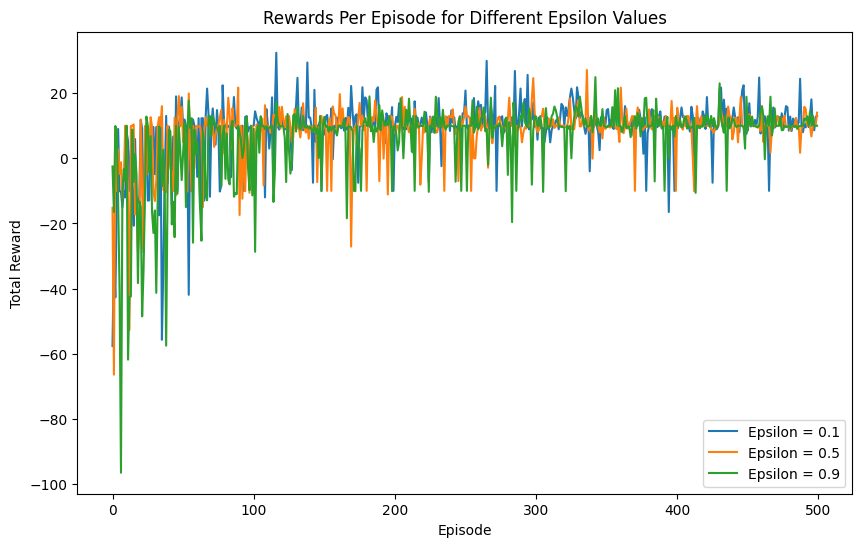

In [29]:
import matplotlib.pyplot as plt

# Define the epsilon values to test
epsilon_values = [0.1, 0.5, 0.9]
num_episodes = 500

# Store the results for each epsilon value
results = {}

# Run the DQN training for each epsilon value and store the rewards
for epsilon in epsilon_values:
    print(f"Running with epsilon = {epsilon}")
    dqn_agent = DQN(state_size, action_size)  # Re-initialize agent for each experiment
    rewards = train_dqn_with_epsilon(mdp, dqn_agent, epsilon, num_episodes=num_episodes)
    results[epsilon] = rewards  # Store the rewards for this epsilon value

# Plot rewards for different epsilon values
plt.figure(figsize=(10, 6))
for epsilon in epsilon_values:
    plt.plot(results[epsilon], label=f"Epsilon = {epsilon}")

plt.title("Rewards Per Episode for Different Epsilon Values")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()